# Treinamento de Rede Neural com Tensorflow para análise do sinal

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-03-01 16:25:48.905908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 16:25:48.905936: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-01 16:25:48.935081: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 16:25:49.643388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 16:25:49.643468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

## Definição e transmissão do sinal pelo canal

In [2]:
Mod = 'PSK'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 8      # PSK modulation
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = [15, 20, 25]      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
faixa_snr = len(SNR_dB)

In [3]:
#plot theoretical symbol error probability (SER) for this SNR
for s in SNR_dB:
    Pe = theoretical_error(Mod, M, s, channel_type, epb=False)
    print("Theoretical symbol error probability (SER) =", Pe*100, "% for SNR =", s,"dB")

Theoretical symbol error probability (SER) = 9.313001117891096 % for SNR = 15 dB
Theoretical symbol error probability (SER) = 3.2487503952584706 % for SNR = 20 dB
Theoretical symbol error probability (SER) = 1.0624926532428969 % for SNR = 25 dB


In [4]:
def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[0])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)

    if scaler is not None:
        x = scaler(np.concatenate((x, np.array([channel_output[1]]).T), axis=1))
    else:
        x = np.concatenate((x, np.array([channel_output[1]]).T), axis=1)
    
    x = x.reshape(1,-1,3)
    
    for i in range(1, len(SNR_dB)):
        a, b, c = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[i])
        
        d = np.stack([np.real(c[0][:]), np.imag(c[0][:])], axis=1)
        
        if scaler is not None:
            d = scaler(np.concatenate((d, np.array([c[1]]).T), axis=1))
        else:
            d = np.concatenate((d, np.array([c[1]]).T), axis=1)
        
        symbs = np.vstack((symbs, a))
        indices = np.vstack((indices, b))
        channel_output = np.vstack((channel_output, c))
        x = np.vstack((x, d.reshape(1,-1,3)))
    
    y = np.float_(indices)
        
    if symb:
        return x, y, symbs
    else:
        return x, y

In [5]:
x_out, y_out, symbs = conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, True)

In [6]:
x_out

array([[[-1.13249038e-01, -9.75359187e-01,  9.12712554e-01],
        [ 8.91424658e-01, -9.57998006e-01,  1.32223732e+00],
        [ 8.80544422e-01,  8.44686674e-01,  1.15643187e+00],
        ...,
        [ 1.26503011e-01,  2.25582016e-01,  3.69451972e-01],
        [ 3.26471852e-02,  3.40609510e-01,  1.17113715e-01],
        [ 2.48075201e+00, -1.00130185e-01,  2.33182810e+00]],

       [[-4.78336354e-01, -7.17829905e-01,  8.21028671e-01],
        [ 5.44738454e-01, -6.88275168e-03,  4.15754139e-01],
        [-1.48881456e-01,  2.61318527e-01,  4.36174470e-01],
        ...,
        [ 7.94623278e-01, -7.42485669e-01,  9.97321434e-01],
        [ 3.96181321e-02, -1.78709140e+00,  1.75757499e+00],
        [-8.67875931e-04,  6.04972680e-01,  4.51443928e-01]],

       [[ 3.99290523e-01, -7.32451091e-02,  4.13682981e-01],
        [ 1.04813730e+00,  1.01760872e+00,  1.42800132e+00],
        [-3.19398903e-02, -1.64480201e-01,  1.77375450e-01],
        ...,
        [ 1.70993558e-01,  2.54435331e-01,

In [7]:
y_out

array([[7., 0., 2., ..., 3., 4., 1.],
       [6., 1., 4., ..., 0., 7., 3.],
       [1., 2., 7., ..., 2., 5., 2.]])

In [8]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:,:train_size]
X_train = x_out[:,:train_size,:]

# Test
y_test = y_out[:,train_size:]
X_test = x_out[:,train_size:,:]

scaler = StandardScaler()
for i in range(faixa_snr):
    scaler.fit(X_train[i])  # Don't cheat - fit only on training data
    X_train[i] = scaler.transform(X_train[i])
    X_test[i] = scaler.transform(X_test[i])


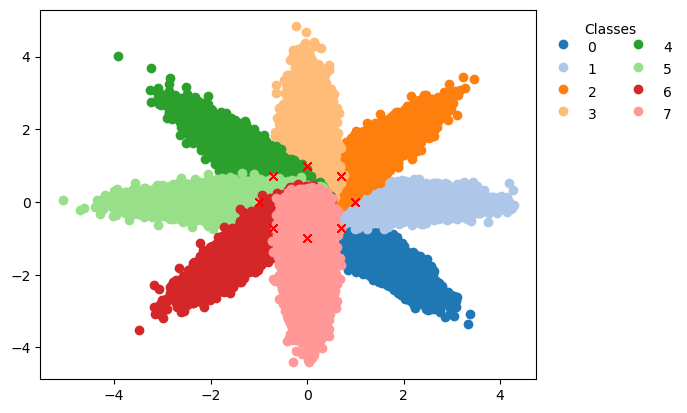

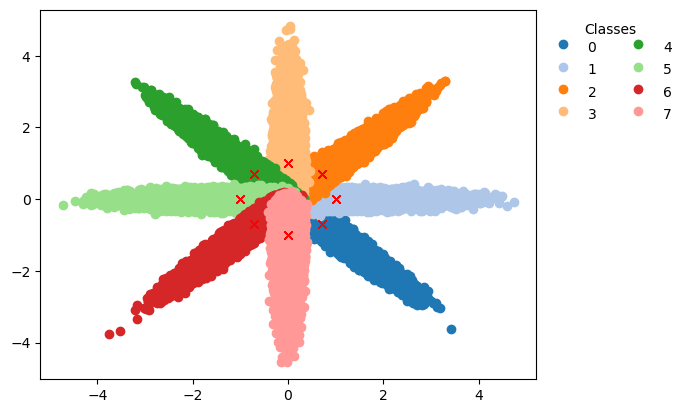

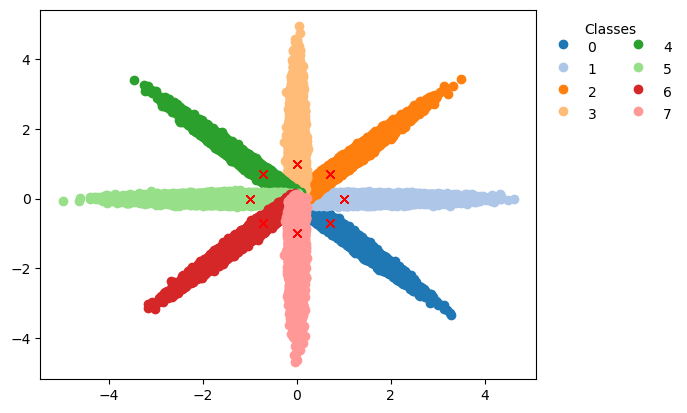

In [9]:
for x, y, s in zip(X_train, y_train, symbs):
    plot_symbols(x, y, M, s)

## Criação e treinamento da Rede Neural

In [10]:
n_inputs = np.shape(X_train[0])[1]
n_hidden1 = 150
n_hidden2 = 80
n_hidden3 = 50

n_outputs = M
learning_rate = 0.01
n_epochs = 10
batch_size = 800

y_train = tf.reshape(tf.convert_to_tensor(y_train), [faixa_snr, -1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [faixa_snr, -1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2023-03-01 16:25:56.323147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 16:25:56.323264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-01 16:25:56.323332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-01 16:25:56.323400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-01 16:25:56.323469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Usando API Keras

In [11]:
inputs = tf.keras.Input(shape=(3,))

x = tf.keras.layers.Dense(n_hidden1, activation="elu", kernel_initializer="glorot_normal")(inputs)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden2, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden3, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)


#output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)
#output = tf.keras.layers.BatchNormalization(momentum=0.99)(output)

In [12]:
model_PSK = np.array([])
for i in range(faixa_snr):
    model_PSK = np.append(model_PSK, tf.keras.Model(inputs=inputs, outputs=tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x), name=f"SNR_{SNR_dB[i]}"))

    model_PSK[i].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
                 metrics=["accuracy"])

    history = model_PSK[i].fit(X_train[i], y_train[i], batch_size=batch_size, epochs=n_epochs, shuffle=True)

    tests_score = model_PSK[i].evaluate(X_test[i], y_test[i])
    print("\nTest loss:", tests_score[0])
    print("Test accuracy:", tests_score[1])
    print(f"Taxa de erro simbólica para SNR = {SNR_dB[i]} de {(1 - tests_score[1]):.2%}\n")

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3414 - accuracy: 0.8926
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2390 - accuracy: 0.9089
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2308 - accuracy: 0.9090
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2284 - accuracy: 0.9091
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2275 - accuracy: 0.9091
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2271 - accuracy: 0.9091
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2267 - accuracy: 0.9092
Epoch 8/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2265 - accuracy: 0.9092
Epoch 9/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2264 - accuracy: 0.9092
Epoch 10/10
15625/15625 [==============================] - 16s 1ms/step - loss: 0.2291 - accuracy: 0

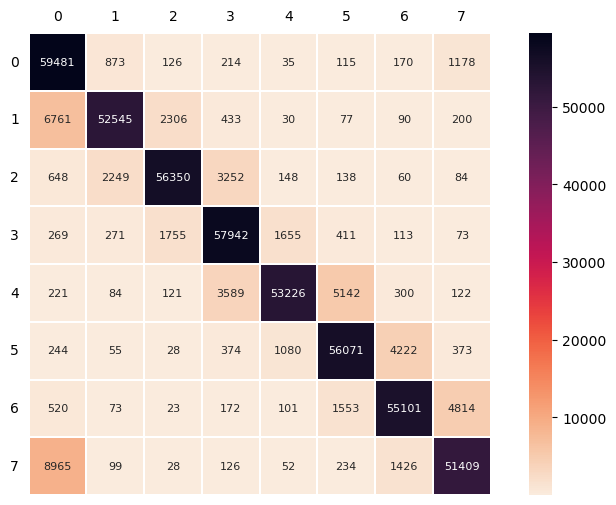

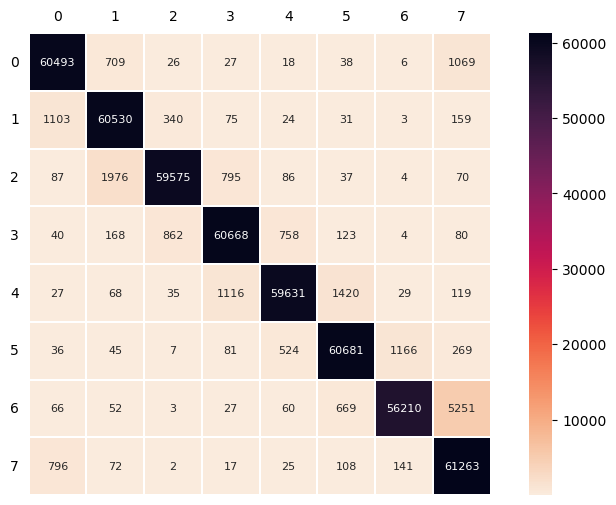

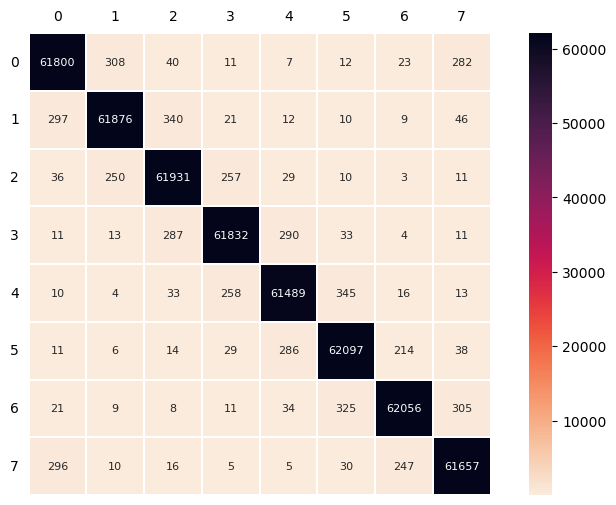

In [14]:
for m, x, y in zip(model_PSK, X_test, y_test):
    plot_confusion_matrix(m, x, y, M, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### PSK | Rayleigh

In [15]:
Mod = "PSK"
channel_type = "rayleigh"
M = 8
init_scale = 2
interval = 50
passo = 4

In [16]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [17]:
amostras = [conjunto(Mod, int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [18]:
error_rate = ([[ser(model_PSK[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1,3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(faixa_snr)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [19]:
error_rate

<tf.Tensor: shape=(3, 13), dtype=float32, numpy=
array([[1.8224740e-01, 1.5026246e-01, 8.0657490e-02, 4.6081211e-02,
        2.1120295e-02, 9.3220631e-03, 5.2780132e-03, 3.3175945e-03,
        2.3625109e-03, 1.9806835e-03, 1.8204502e-03, 1.7558775e-03,
        1.7275037e-03],
       [1.8413597e-01, 1.4829396e-01, 7.6834865e-02, 4.6081211e-02,
        1.9450705e-02, 9.1481442e-03, 4.4171605e-03, 2.6948380e-03,
        1.8402716e-03, 1.5157004e-03, 1.4249185e-03, 1.3547097e-03,
        1.3256712e-03],
       [1.7941456e-01, 1.4435695e-01, 7.0718654e-02, 3.8526911e-02,
        1.6946323e-02, 6.9219801e-03, 2.9777025e-03, 1.1945606e-03,
        4.6798063e-04, 1.9284179e-04, 1.1844412e-04, 7.6317643e-05,
        5.5762634e-05]], dtype=float32)>

In [20]:
np.mean(error_rate - Teo_SNRs)

0.0020986865

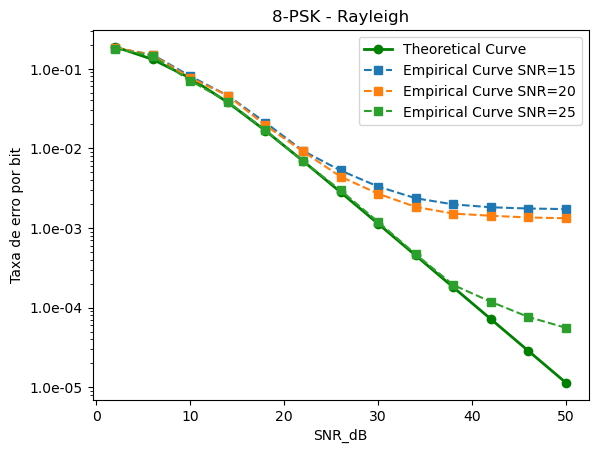

In [21]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, y2,'s--', label=(f"Empirical Curve SNR={SNR_dB[i]}")) for i, y2 in enumerate(error_rate)]
ax.set_title('8-PSK - Rayleigh')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

### PSK | AWGN

In [22]:
Mod = 'PSK'
channel_type = 'awgn'
interval = 17
init_scale = 2
passo = 2

In [23]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [24]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [25]:
error_rate = ([[ser(model_PSK[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1,3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(faixa_snr)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [26]:
error_rate

<tf.Tensor: shape=(3, 9), dtype=float32, numpy=
array([[1.78981945e-01, 1.23697914e-01, 9.99066308e-02, 5.57491295e-02,
        4.17754538e-02, 2.42329687e-02, 1.21353818e-02, 4.69501549e-03,
        1.40756706e-03],
       [1.62561581e-01, 1.28906250e-01, 9.61718038e-02, 5.51684089e-02,
        4.20655645e-02, 2.29849201e-02, 1.03985751e-02, 4.12676111e-03,
        1.40499219e-03],
       [1.64203614e-01, 1.34114578e-01, 9.24369767e-02, 4.23925668e-02,
        3.24920230e-02, 1.16484659e-02, 2.96147843e-03, 4.63967997e-04,
        2.76386272e-05]], dtype=float32)>

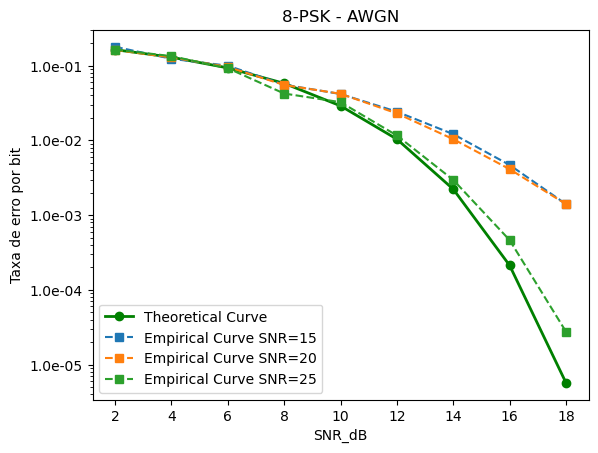

In [27]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, y2,'s--', label=(f"Empirical Curve SNR={SNR_dB[i]}")) for i, y2 in enumerate(error_rate)]
ax.set_title('8-PSK - AWGN')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

## Modelo QAM

In [28]:
Mod = "QAM"
channel_type = "rayleigh"
M = 16

In [29]:
x_out, y_out, symbs = conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, True)

In [30]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:,:train_size]
X_train = x_out[:,:train_size,:]

# Test
y_test = y_out[:,train_size:]
X_test = x_out[:,train_size:,:]

scaler = StandardScaler()
for i in range(faixa_snr):
    scaler.fit(X_train[i])  # Don't cheat - fit only on training data
    X_train[i] = scaler.transform(X_train[i])
    X_test[i] = scaler.transform(X_test[i])


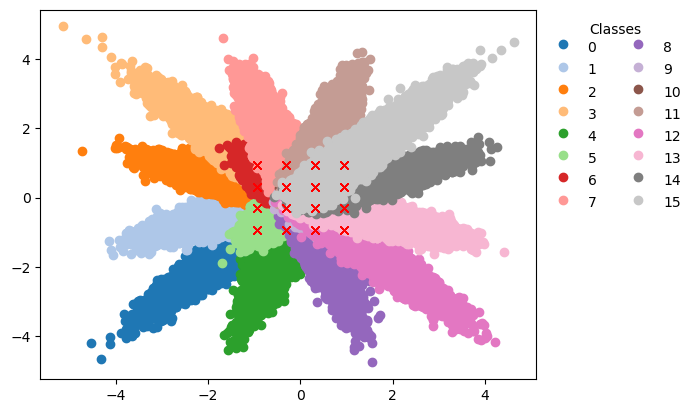

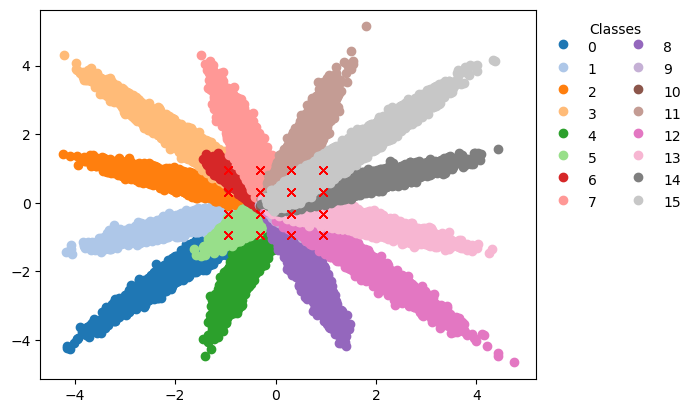

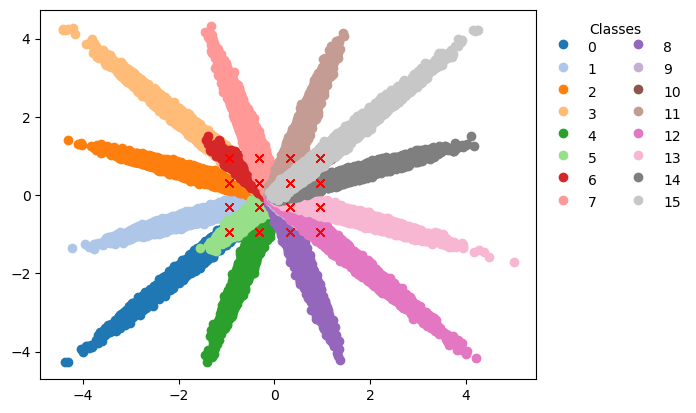

In [31]:
for x, y, s in zip(X_train, y_train, symbs):
    plot_symbols(x, y, M, s)

## Criação e treinamento da Rede Neural

In [32]:
n_inputs = np.shape(X_train[0])[1]
#n_hidden1 = 300
n_hidden1 = 150
n_hidden2 = 80
n_hidden3 = 50

n_outputs = M
learning_rate = 0.001
n_epochs = 10
batch_size = 800

y_train = tf.reshape(tf.convert_to_tensor(y_train), [faixa_snr, -1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [faixa_snr, -1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

### Usando API Keras

In [33]:
inputs = tf.keras.Input(shape=(3,))

x = tf.keras.layers.Dense(n_hidden1, activation="elu", kernel_initializer="glorot_normal")(inputs)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden2, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden3, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

#x = tf.keras.layers.Dense(n_hidden4, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

#output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)
#output = tf.keras.layers.BatchNormalization(momentum=0.99)(output)

In [34]:
model_QAM = np.array([])
for i in range(faixa_snr):
    model_QAM = np.append(model_QAM, tf.keras.Model(inputs=inputs, outputs=tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)))

    model_QAM[i].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
                 metrics=["accuracy"])

    history = model_QAM[i].fit(X_train[i], y_train[i], batch_size=batch_size, epochs=n_epochs, shuffle=True)

    tests_score = model_QAM[i].evaluate(X_test[i], y_test[i])
    print("\nTest loss:", tests_score[0])
    print("Test accuracy:", tests_score[1])
    print(f"Taxa de erro simbólica para SNR = {SNR_dB[i]} de {(1 - tests_score[1]):.2%}\n")

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 1.9715 - accuracy: 0.4226
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.9850 - accuracy: 0.7848
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6503 - accuracy: 0.8241
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5572 - accuracy: 0.8286
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5270 - accuracy: 0.8311
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5130 - accuracy: 0.8326
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5044 - accuracy: 0.8337
Epoch 8/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4979 - accuracy: 0.8345
Epoch 9/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4923 - accuracy: 0.8352
Epoch 10/10
15625/15625 [==============================] - 16s 1ms/step - loss: 0.4845 - accuracy: 0

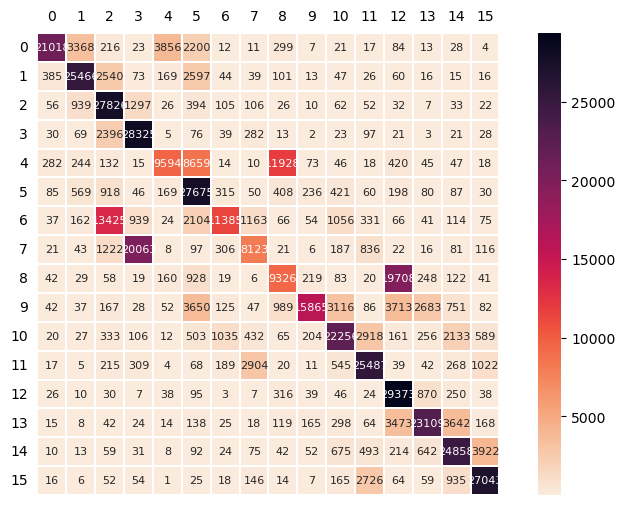

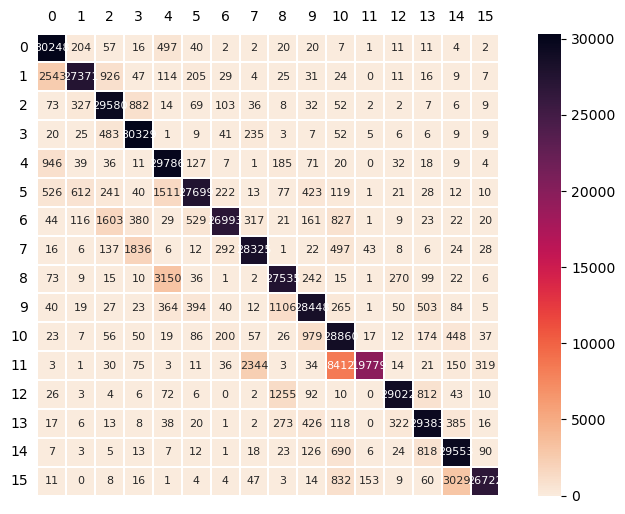

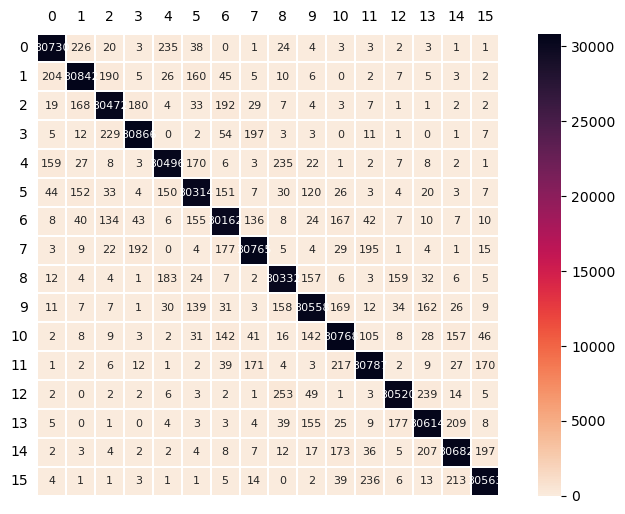

In [35]:
for m, x, y in zip(model_QAM, X_test, y_test):
    plot_confusion_matrix(m, x, y, M, nn=True)
#plot_decision_boundary(modelQ, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelQ, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | Rayleigh

In [36]:
Mod = 'QAM'
channel_type = 'rayleigh'
M = 16
init_scale = 2
interval = 48
passo = 4

In [37]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [38]:
amostras = [conjunto(Mod, int(200 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [39]:
error_rate = ([[ser(model_QAM[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1,3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(faixa_snr)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [40]:
error_rate

<tf.Tensor: shape=(3, 12), dtype=float32, numpy=
array([[1.8483412e-01, 1.6842106e-01, 1.1813187e-01, 7.8414351e-02,
        6.5957449e-02, 5.6214690e-02, 5.0277393e-02, 4.6443459e-02,
        4.6008661e-02, 4.5549255e-02, 4.6317384e-02, 4.6280488e-02],
       [1.8009479e-01, 1.5000001e-01, 1.0989011e-01, 6.4525463e-02,
        3.5106383e-02, 1.7005650e-02, 1.0702727e-02, 7.2303284e-03,
        5.6934045e-03, 5.1378706e-03, 4.8954920e-03, 4.7957795e-03],
       [1.7180094e-01, 1.4122806e-01, 1.0000000e-01, 4.4849537e-02,
        2.4601065e-02, 9.7175138e-03, 4.4382801e-03, 1.7122013e-03,
        7.8889006e-04, 4.0515271e-04, 1.8032911e-04, 1.2525676e-04]],
      dtype=float32)>

In [41]:
np.mean(error_rate - Teo_SNRs)

0.00484419

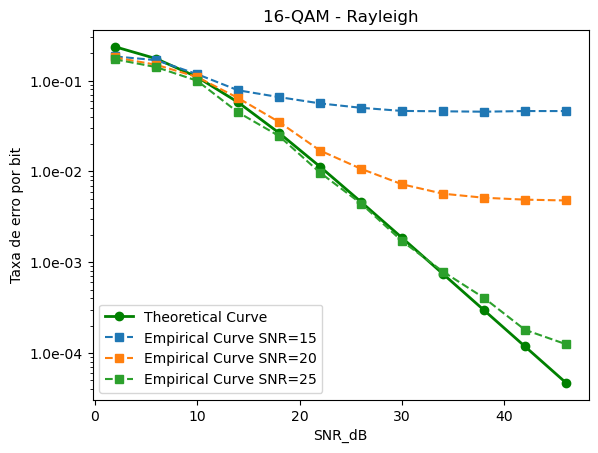

In [42]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, y2,'s--', label=(f"Empirical Curve SNR={SNR_dB[i]}")) for i, y2 in enumerate(error_rate)]
ax.set_title('16-QAM - Rayleigh')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

### QAM | AWGN

In [43]:
Mod = 'QAM'
channel_type = 'awgn'
init_scale = 2
interval = 19
passo = 2

In [44]:
Teo_SNRs = [theoretical_error(Mod, M, init_scale + i, channel_type) for i in range(0, interval, passo)]

In [45]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[int(i / passo)] * np.log2(M))), M, channel_type, Es, code_rate, [init_scale + i], False, scaler.transform) for i in range(0, interval, passo)]

In [46]:
error_rate = ([[ser(model_QAM[j], tf.reshape(tf.convert_to_tensor(amostras[i][0]), [-1,3]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(len(amostras))] for j in range(faixa_snr)]) / (tf.math.log(float(M))/tf.math.log(2.))

In [47]:
error_rate

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[1.7736487e-01, 1.4792900e-01, 1.3822116e-01, 1.2145390e-01,
        8.8888891e-02, 7.2210066e-02, 6.1780006e-02, 5.3157631e-02,
        4.7250170e-02, 4.4956446e-02],
       [1.7905405e-01, 1.5236686e-01, 1.2980770e-01, 9.8404258e-02,
        7.3888890e-02, 4.3763675e-02, 3.0379042e-02, 1.4751108e-02,
        8.5996594e-03, 4.2040520e-03],
       [1.5709460e-01, 1.4644970e-01, 1.2740384e-01, 8.8652484e-02,
        6.1666667e-02, 3.0634573e-02, 1.1984392e-02, 2.9681018e-03,
        4.6527208e-04, 3.0870295e-05]], dtype=float32)>

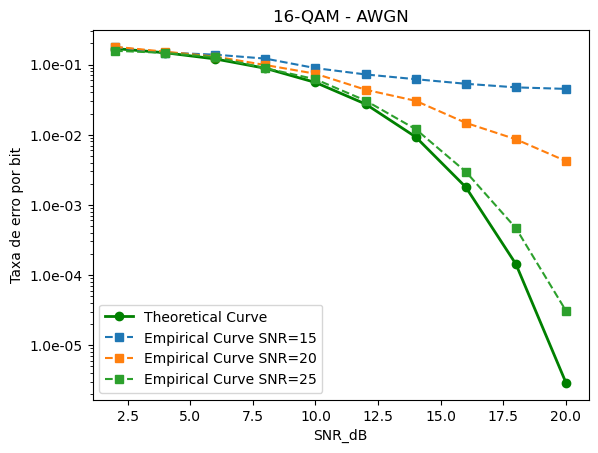

In [48]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(init_scale, init_scale + interval, passo)

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
[ax.plot(x, y2,'s--', label=(f"Empirical Curve SNR={SNR_dB[i]}")) for i, y2 in enumerate(error_rate)]
ax.set_title('16-QAM - AWGN')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Taxa de erro por bit')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()